In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from interpolation import sequences, dataprocessing, archive

### Notebook Summary: 
**Goal:** Create enumeration sequences\
**Problem:** Intuitively, an enumeration sequence would be a list of dwellings/households that an enumerator visited consecutively without stopping. It follows that these sequences could help bring geographic specificity to the data. However, the census data available doesn't include direct indicators of when these sequences begin or end, so we would need to create some kind of proxy\
**Method:** Use distance between known dwellings to generate sequences.
1. Calculate haversine distance between known consecutive dwellings
2. Select a maximum possible distance between two dwellings
3. Create sequences, separating them when distance between consecutive dwellings exceeds the maximum selected

**In this notebook:** This notebook shows how this approach to sequencing was developed, and the reasoning behind it. The code is outdated, and doesn't make use of the current structure, but is still runable

***note:*** *this may fail if used with new data because of different column names. However, using new data is not recommended because this notebook is solely meant to demonstrate the development process. For use and analysis of this type of sequence on new data please see disambiguation_analysis_v01.ipynb.*

#### Get Data

In [2]:
#This represents all 1850 census data with address information from disambiguation, after resolving dwelling conflicts
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../../data/census_1880_mn_blocks.csv")
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB"}, inplace = True)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dwellings_1850 = filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()

#### Explore geography of known data points

In [4]:
dwellings_1850_ward_1 = dwellings_1850[dwellings_1850["WARD_NUM"] == 1].copy()
print("Range of block numbers in ward 1:", min(dwellings_1850_ward_1["BLOCK_NUM"]), max(dwellings_1850_ward_1["BLOCK_NUM"]))
print("Total number of blocks in ward 1:",dwellings_1850_ward_1["BLOCK_NUM"].nunique())

Range of block numbers in ward 1: 1.0 3802.0
Total number of blocks in ward 1: 68


This indicates that very large differences in block numbers don't necessarily correspond to correspond to huge geographic breaks in the enumeration pattern. Let's try graphing one ward and trying to get a sense of where things are.

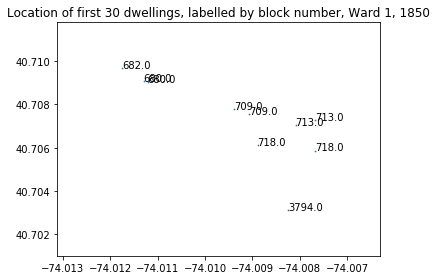

In [5]:
dwellings_1850_ward_1 = dwellings_1850_ward_1[0:30]
plt.scatter(dwellings_1850_ward_1["CD_X"], dwellings_1850_ward_1["CD_Y"], s = 0.5)
for x, y, block in zip(dwellings_1850_ward_1["CD_X"], dwellings_1850_ward_1["CD_Y"], dwellings_1850_ward_1["BLOCK_NUM"]):
    plt.annotate(block, (x,y))
plt.title("Location of first 30 dwellings, labelled by block number, Ward 1, 1850")
plt.tight_layout()
plt.show()

So an overlay here would probably be more useful, but this works to get a sense of what's happening. Since the geography is signficant intuitively, could we create sequences by using a distance as a measurement? The problem here is that we couldn't really assume a street but doing that on a grand scale is somewhat problematic regardless. Having sequences that actually make sense would be really helpful

#### Calculate and analyze the distance between dwellings with known addresses (from disambiguation)

In [6]:
#This preserves the original index, we can get the number of dwellings in between later on 
#Get data with known addresses, coordinates from disambiguation
dwellings_1850_add = dwellings_1850.dropna(subset = ["CD_ADDRESS"]).copy() 
dwellings_1850_add.head()

,WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_PAGENO_HOUSEHOLD,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALB,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,70,MANHATTAN,120,534,1,2044262,1,1.0,2.00,2.00
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,100,MANHATTAN,120,534,1,2044350,1,1.0,1.74,1.74
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,110,MANHATTAN,120,534,1,2044352,1,1.0,2.00,2.00
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,110,MANHATTAN,120,534,1,2044353,1,1.0,1.95,1.95
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,110,MANHATTAN,120,534,1,2044355,1,1.0,1.96,1.96


In [7]:
dwellings_1850_add = dwellings_1850_add.groupby("WARD_NUM", as_index = False).apply(lambda x: sequences.col_for_seq(x,"CD_X", "CD_Y"))
dwellings_1850_add.head()

,WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum,dwelling_num_listed,next_dnl,next_x,next_y,dist,num_between
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,1,1.0,2.00,2.00,0,3.0,-74.007679,40.707284,0.088400,3.0
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,1,1.0,1.74,1.74,3,5.0,-74.009067,40.707572,0.096077,2.0
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,1,1.0,2.00,2.00,5,6.0,-74.011747,40.709673,0.189482,1.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,1,1.0,1.95,1.95,6,8.0,-74.007680,40.705869,0.290189,2.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,1,1.0,1.96,1.96,8,20.0,-74.009386,40.707772,0.123281,12.0


In [8]:
print("Distance Range:", min(dwellings_1850_add["dist"]), "-", max(dwellings_1850_add["dist"]))

Distance Range: 0.0 - 1.2561718692407418


Investigation indicated that distances with 0 represented consecutive dwellings assigned the same address

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


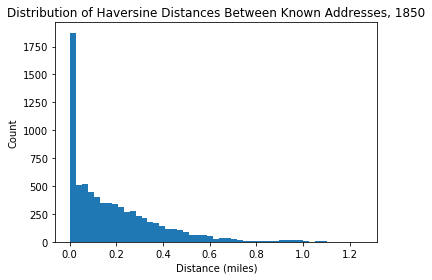

In [9]:
### Let's look at the distribution of distances
plt.hist(dwellings_1850_add["dist"], bins = "auto")
plt.title("Distribution of Haversine Distances Between Known Addresses, 1850")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Experiment with choosing different maximum distances

Looking at this graph, and considering that these are the distances between consecutive dwellings, let's try sequences split on when it's farther than 0.1 to the next dwelling

In [10]:
dwellings_1850_add["sequence_id"] = np.where(dwellings_1850_add["dist"] > 0.1, dwellings_1850_add["dist"].index, np.nan)

In [11]:
dwellings_1850_add.head()

,WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,selected,spatial_weight,spatial_weight_sum,dwelling_num_listed,next_dnl,next_x,next_y,dist,num_between,sequence_id
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,1.0,2.00,2.00,0,3.0,-74.007679,40.707284,0.088400,3.0,NaN
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,1.0,1.74,1.74,3,5.0,-74.009067,40.707572,0.096077,2.0,NaN
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,1.0,2.00,2.00,5,6.0,-74.011747,40.709673,0.189482,1.0,5.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,1.0,1.95,1.95,6,8.0,-74.007680,40.705869,0.290189,2.0,6.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,1.0,1.96,1.96,8,20.0,-74.009386,40.707772,0.123281,12.0,8.0


In [12]:
dwellings_1850_add["sequence_id"].bfill(inplace = True)
dwellings_1850_add.head()

,WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,selected,spatial_weight,spatial_weight_sum,dwelling_num_listed,next_dnl,next_x,next_y,dist,num_between,sequence_id
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,1.0,2.00,2.00,0,3.0,-74.007679,40.707284,0.088400,3.0,5.0
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,1.0,1.74,1.74,3,5.0,-74.009067,40.707572,0.096077,2.0,5.0
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,1.0,2.00,2.00,5,6.0,-74.011747,40.709673,0.189482,1.0,5.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,1.0,1.95,1.95,6,8.0,-74.007680,40.705869,0.290189,2.0,6.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,1.0,1.96,1.96,8,20.0,-74.009386,40.707772,0.123281,12.0,8.0


In [13]:
dwellings_1850_add.groupby("sequence_id").ngroups

4195

In [14]:
dwellings_1850_add["sequence_len"] = dwellings_1850_add.groupby("sequence_id")["num_between"].transform('sum')
dwellings_1850_add.head()

,WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,spatial_weight,spatial_weight_sum,dwelling_num_listed,next_dnl,next_x,next_y,dist,num_between,sequence_id,sequence_len
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,2.00,2.00,0,3.0,-74.007679,40.707284,0.088400,3.0,5.0,6.0
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,1.74,1.74,3,5.0,-74.009067,40.707572,0.096077,2.0,5.0,6.0
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,2.00,2.00,5,6.0,-74.011747,40.709673,0.189482,1.0,5.0,6.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,1.95,1.95,6,8.0,-74.007680,40.705869,0.290189,2.0,6.0,2.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,1.96,1.96,8,20.0,-74.009386,40.707772,0.123281,12.0,8.0,12.0


In [15]:
print("Range of sequence lengths:", min(dwellings_1850_add["sequence_len"]), "-", max(dwellings_1850_add["sequence_len"]))

Range of sequence lengths: 1.0 - 1084.0


get_dist_seq and a tuning process for selecting the best maximum distance were formalized, and current versions are in sequences.py

In [16]:
#Note this function was restructured in sequences.py, in restructured version it's meant
#to be applied with groupby(WARD_NUM) so sequences do not cross wards
def get_dist_seq(dataframe, d):
    df = dataframe.copy()
    df["sequence_id"] = np.where(df["dist"] > d, df["dist"].index, np.nan)
    df["sequence_id"].bfill(inplace = True)
    df["sequence_id"].fillna(df.tail(1).index[0], inplace = True)
    df["sequence_len"] = df.groupby("sequence_id")["num_between"].transform('sum')
    return [min(df["sequence_len"]), max(df["sequence_len"]), df]

In [17]:
# Let's test a few sequence division options
options = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for op in options:
    obj = get_dist_seq(dwellings_1850_add, op)
    print("Minimum Length with division dist", op, ":", obj[0])
    print("Maximum Length with division dist", op, ":", obj[1])

Minimum Length with division dist 0.1 : 0.0
Maximum Length with division dist 0.1 : 1084.0
Minimum Length with division dist 0.15 : 1.0
Maximum Length with division dist 0.15 : 1084.0
Minimum Length with division dist 0.2 : 1.0
Maximum Length with division dist 0.2 : 1084.0
Minimum Length with division dist 0.25 : 1.0
Maximum Length with division dist 0.25 : 1084.0
Minimum Length with division dist 0.3 : 1.0
Maximum Length with division dist 0.3 : 1421.0
Minimum Length with division dist 0.35 : 1.0
Maximum Length with division dist 0.35 : 1421.0
Minimum Length with division dist 0.4 : 1.0
Maximum Length with division dist 0.4 : 1421.0


This indicates that 0.15 may make the most sense as far as a division goes, there's still a huge amount of variablity in the sequence lengths though. Let's look at the really short sequences.

In [18]:
dwellings_1850_seq  = get_dist_seq(dwellings_1850_add, .15)[2]
dwellings_1850_seq[dwellings_1850_seq["sequence_len"] == 1]

,WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,spatial_weight,spatial_weight_sum,dwelling_num_listed,next_dnl,next_x,next_y,dist,num_between,sequence_id,sequence_len
58,1,59.0,3781.0,47 Front,-74.009378,40.703039,46,4610,95.0,32,...,1.88,1.88,58,59.0,-74.014034,40.706597,0.328745,1.0,58.0,1.0
66,1,67.0,682.0,123 Cedar,-74.012489,40.709591,40,4610,135.0,6,...,1.88,1.88,66,67.0,-74.008438,40.704024,0.299281,1.0,66.0,1.0
71,1,72.0,3797.0,12 Stone:,-74.012247,40.703998,30,4610,151.0,6,...,1.96,1.96,71,72.0,-74.005920,40.705107,0.437609,1.0,71.0,1.0
72,1,73.0,707.0,93 Pine,-74.005920,40.705107,25,4610,157.0,2,...,1.87,1.87,72,73.0,-74.013065,40.702812,0.495584,1.0,72.0,1.0
73,1,74.0,649.0,40 Whitehall,-74.013065,40.702812,60,4610,160.0,14,...,1.84,1.84,73,74.0,-74.009819,40.708802,0.251584,1.0,73.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17689,18,785.0,1627.0,109 Elizabeth,-73.983044,40.741673,40,4610,1829.0,13,...,1.82,1.82,17689,17690.0,-73.987308,40.739808,0.296763,1.0,17689.0,1.0
17773,18,869.0,634.0,296 Fourth _,-73.986612,40.740092,45,4610,1957.0,5,...,1.98,1.98,17773,17774.0,-73.978227,40.740130,0.579305,1.0,17773.0,1.0
17810,18,906.0,453.0,88 Broadway,-73.982553,40.742304,60,4610,1994.0,10,...,1.90,1.90,17810,17811.0,-73.986868,40.744981,0.302443,1.0,17810.0,1.0
17825,18,921.0,452.0,E . 32d c . Lexington Av,-73.982931,40.742213,52,4610,2009.0,20,...,2.00,2.00,17825,17826.0,-73.988330,40.734795,0.398963,1.0,17825.0,1.0


In [19]:
dwellings_1850_seq.groupby("sequence_id").ngroups

3454

#### Visualizing sequences

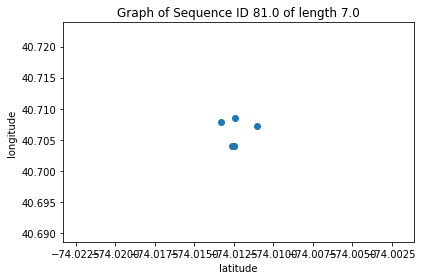

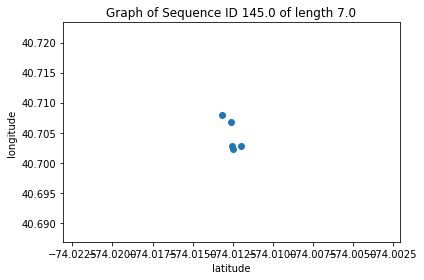

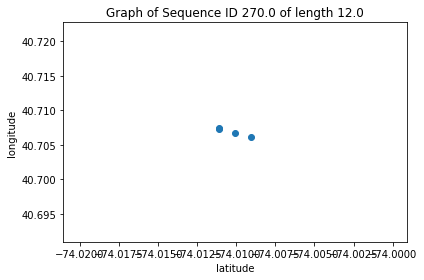

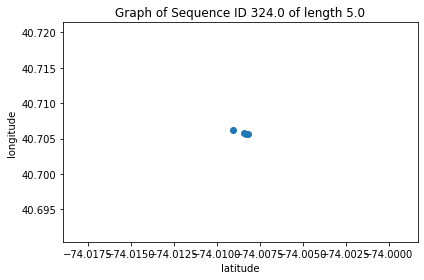

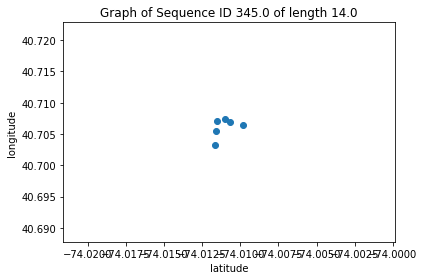

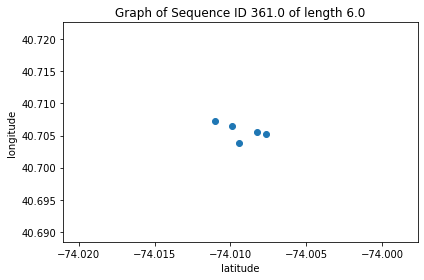

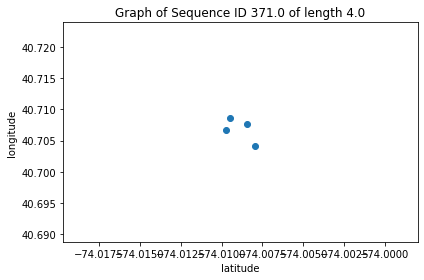

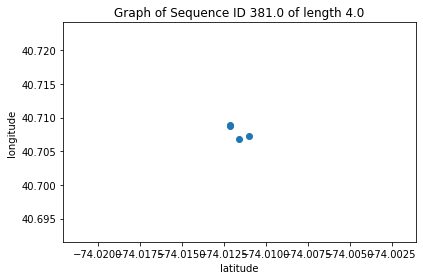

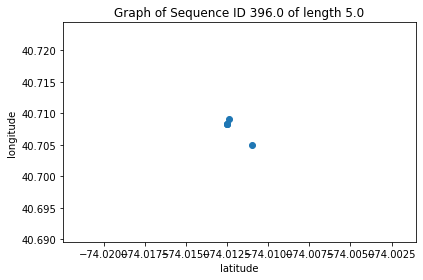

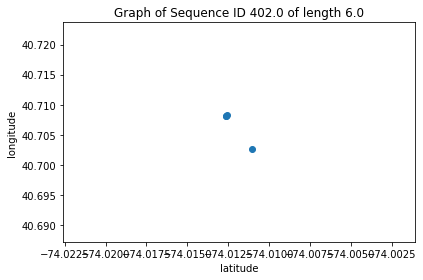

In [20]:
# Let's try plotting some sequences so that we can see whether they look sort of like sequences
i = 0
for id, group in dwellings_1850_seq.groupby("sequence_id"):
    if len(group) > 3:
        plt.scatter(group["CD_X"], group["CD_Y"])
        plt.title("Graph of Sequence ID "+str(id)+ " of length " + str(group["sequence_len"].iloc[0]))
        plt.xlabel("latitude")
        plt.ylabel("longitude")
        plt.tight_layout()
        plt.show()
        i += 1
    if i == 10:
        break

Again, it would be great to get an overlay here, but from a visual inspection these sequences look like they make some level of sense. I think it makes sense to try them in the linear model for now, as a category and see if they help. It may also be worth experimenting with the options for including the sequence order

#### Add sequences to all census records

In [21]:
#Add sequences into the orginal data
all_seq = dataprocessing.dwellings_to_all(filled_1850, dwellings_1850_seq, ["WARD_NUM", "CENSUS_DWELLING_NUM", "sequence_id"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
#filled_1850.dropna(subset = ["CD_ADDRESS"]).merge(dwellings_1850_seq.loc[:,["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM", "sequence_id"]], how = 'left', on = ["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], validate = 'many_to_one')
all_seq.head()

,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALB,CENSUS_SEX,WARD_NUM,selected,spatial_weight,spatial_weight_sum,sequence_id
0,3794.0,37 South,-74.00825,40.703128,49,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,1,2044262,1,1,NaN,NaN,NaN,5.0
1,3794.0,37 South,-74.00825,40.703128,36,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,2,2044263,2,1,NaN,NaN,NaN,5.0
2,3794.0,37 South,-74.00825,40.703128,12,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,3,2044264,2,1,NaN,NaN,NaN,5.0
3,3794.0,37 South,-74.00825,40.703128,40,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,4,2044265,1,1,NaN,NaN,NaN,5.0
4,3794.0,37 South,-74.00825,40.703128,28,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,5,2044266,2,1,NaN,NaN,NaN,5.0


#### Try sequences with 1880 census data

In [22]:
dwellings_1880 = census_1880.drop_duplicates(subset = ["CENSUS_ADDRESS"]).reset_index(drop = True).copy()
#Note ask Dan about this
dwellings_1880.loc[dwellings_1880.CENSUS_Y > 1000, 'CENSUS_Y'] = 40.799935
dwellings_1880 = dwellings_1880.groupby("WARD_NUM", as_index = False).apply(lambda x: sequences.col_for_seq(x, "CENSUS_X", "CENSUS_Y"))

In [23]:
print("Maximum distance:", max(dwellings_1880["dist"]))
print("Minimum distance:", min(dwellings_1880["dist"]))

Maximum distance: 4.406896866285562
Minimum distance: 0.00029922284205678864


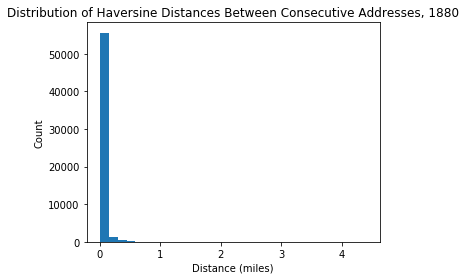

In [24]:
plt.hist(dwellings_1880["dist"], bins =  30)
plt.title("Distribution of Haversine Distances Between Consecutive Addresses, 1880")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
#plt.ylim([0,10000])
plt.tight_layout()
plt.show()

In [25]:
seq_1880 = dwellings_1880.groupby("WARD_NUM", as_index = False).apply(lambda x: get_dist_seq(x, .15)[2])

In [26]:
all_seq_1880 = dataprocessing.dwellings_to_all(census_1880, seq_1880, ["CENSUS_MATCH_ADDR", "sequence_id"], "CENSUS_MATCH_ADDR")

In [27]:
dataprocessing.create_street_house(all_seq_1880, "CENSUS_ADDRESS")
dataprocessing.create_street_house(all_seq, "CD_ADDRESS")

### Linear model using sequences for predicting house number

*Note: This modeling approach is outdated, please do not use in the future. It's simply meant to give a sense of the utility of these sequences.*

In [28]:
all_seq["sequence_id"].ffill(inplace = True)
all_seq_1880["sequence_id"].ffill(inplace = True)

In [29]:
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = archive.create_train_test_data(all_seq_1880, all_seq, ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id"])

#### Without Sequences

In [30]:
cols = ["CENSUS_SERIALB","WARD_NUM","street_name"]
targetencoder = TargetEncoder(cols = cols).fit(train_X, train_y)
train_X = targetencoder.transform(train_X, train_y)
test_1880_X = targetencoder.transform(test_1880_X)
test_1850_X = targetencoder.transform(test_1850_X)

In [31]:
model_lin_order = LinearRegression()
print("Modeling Results without sequences")
model_lin_order.fit(train_X.loc[:,cols], train_y)
print("Training score:", model_lin_order.score(train_X.loc[:,cols], train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X.loc[:,cols], test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X.loc[:,cols], test_1880_y))

Modeling Results without sequences
Training score: 0.9667249310333793
Test 1850 score: 0.7842177035410774
Test 1880 score: 0.8714259486000273


#### With Sequences 

In [32]:
cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id"]
targetencoder = TargetEncoder(cols = cols).fit(train_X, train_y)
train_X = targetencoder.transform(train_X, train_y)
test_1880_X = targetencoder.transform(test_1880_X)
test_1850_X = targetencoder.transform(test_1850_X)

In [33]:
print("Modeling Results with sequence ids")
model_lin_order = LinearRegression()
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))

Modeling Results with sequence ids
Training score: 0.973211429095396
Test 1850 score: 0.8275757528772977
Test 1880 score: 0.8871277727319096


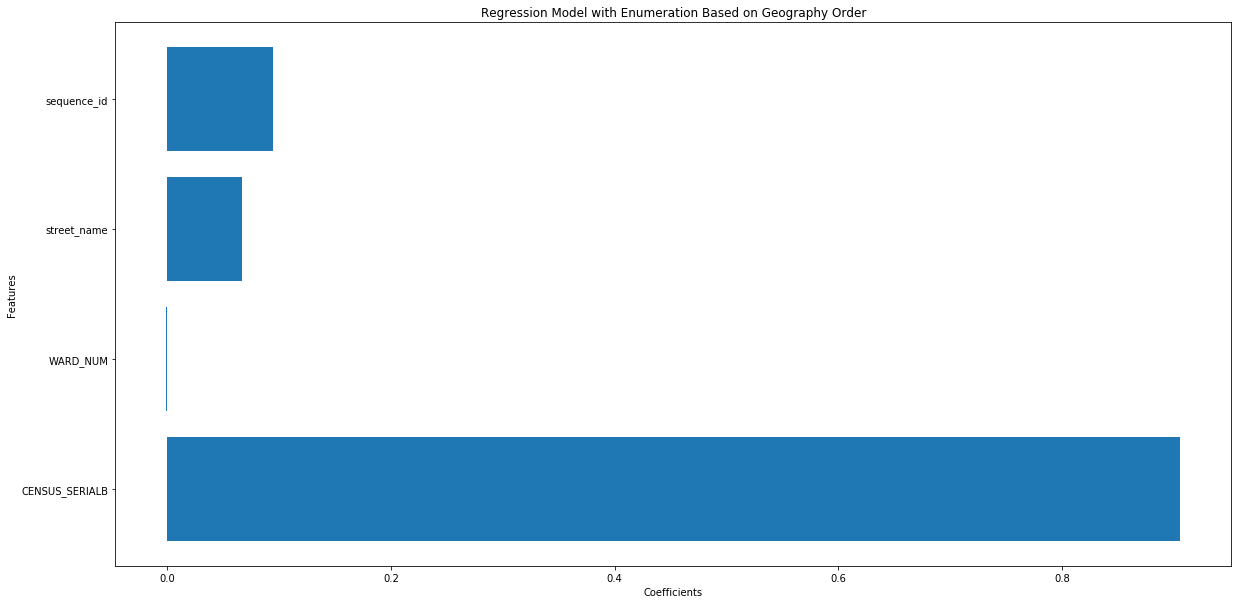

In [34]:
archive.graph_coefs(targetencoder.get_feature_names(), model_lin_order.coef_, "Regression Model with Enumeration Based on Geography Order")

#### With Dwelling Order Within Sequences

Creating sequences this way works pretty well. Let's try incorporating order of the sequence beyond the sequence id.

In [35]:
dwelling_seq_1850_order = dwellings_1850_seq.groupby("sequence_id").apply(sequences.sequence_order)
dwelling_seq_1850_order_dropped = dwelling_seq_1850_order.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
dwelling_seq_1880_order = seq_1880.groupby("sequence_id").apply(sequences.sequence_order)
dwelling_seq_1880_order.head() # Yay, this looks like i's working as expected!

OBJECTID.x           CENSUS_MERGEID  CENSUS_SERIALB  CENSUS_SERIAL  \
0 0         1.0   46101106EDITH K.SANGER       6347938.0      6198399.0   
  1         7.0    4610121181JAMES E.---       6347939.0            0.0   
  2         9.0        461010HENRY W.---       6347940.0            0.0   
  3        16.0          461011007MAY---       6347941.0            0.0   
  4        23.0  461011503AGNESCREIGHTEN       6347942.0      6198403.0   

     CENSUS_PERNUM          CENSUS_RECIDUS  CENSUS_REEL  CENSUS_VOLUME  \
0 0            3.0  01254866-1-0001-0003-$        866.0            1.0   
  1            1.0  01254866-1-0001-0007-$        866.0            1.0   
  2            0.0                     NaN          0.0            0.0   
  3            3.0  01254866-1-0001-0017-$        866.0            1.0   
  4            3.0  01254866-1-0001-0024-$        866.0            1.0   

     CENSUS_PAGENUM CENSUS_NAMEFRSTB  ... block_num  dwelling_num_listed  \
0 0             1.0         EDITH K.  ...       NaN                  0.0   
  1             1.0         JAMES E.  ...       NaN                  1.0   
  2             0.0         HENRY W.  ...       NaN                  2.0   
  3             1.0              MAY  ...       NaN                  3.0   
  4             1.0            AGNES  ...       NaN                  4.0   

    next_dnl     next_x     next_y      dist  num_between  sequence_id  \
0 0      1.0 -74.016451  40.690645  0.020766          1.0         20.0   
  1      2.0 -74.017310  40.691119  0.060032          1.0         20.0   
  2      3.0 -74.016725  40.690844  0.040757          1.0         20.0   
  3      4.0 -74.017031  40.690915  0.021186          1.0         20.0   
  4      5.0 -74.015465  40.689925  0.109828          1.0         20.0   

    sequence_len  sequence_order  
0 0         21.0             1.0  
  1         21.0             2.0  
  2         21.0             3.0  
  3         21.0             4.0  
  4         21.0             5.0  

[5 rows x 56 columns]

In [36]:
#For right now let's try leaving the ordinal variable as is, right now it's basically ordinal encoding
#I'm concerned that the scaling will cause issues because some sequences are pretty long, if so min-max 
#scaling may be worth trying
all_seq_1880 = dataprocessing.dwellings_to_all(census_1880, dwelling_seq_1880_order, ["CENSUS_MATCH_ADDR", "sequence_id", "sequence_order"], "CENSUS_MATCH_ADDR")
#census_1880.merge(dwelling_seq_1880_order.loc[:,["CENSUS_MATCH_ADDR", "sequence_id", "sequence_order"]], how = "left", on = "CENSUS_MATCH_ADDR",validate = "many_to_one")
#work out what's happening here?
all_seq = dataprocessing.dwellings_to_all(filled_1850, dwelling_seq_1850_order_dropped, ["WARD_NUM", "CENSUS_DWELLING_NUM", "sequence_id", "sequence_order"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
#filled_1850.dropna(subset = ["CD_ADDRESS"]).merge(dwelling_seq_1850_order_dropped.loc[:,["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM", "sequence_id", "sequence_order"]], how = 'left', on = ["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], validate = 'many_to_one')

In [37]:
dataprocessing.create_street_house(all_seq_1880, "CENSUS_ADDRESS")
dataprocessing.create_street_house(all_seq, "CD_ADDRESS")
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = archive.create_train_test_data(all_seq_1880, all_seq, ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"])

In [38]:
cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"]
targetencoder = TargetEncoder(cols = cols).fit(train_X, train_y)
train_X = targetencoder.transform(train_X, train_y)
test_1880_X = targetencoder.transform(test_1880_X)
test_1850_X = targetencoder.transform(test_1850_X)

In [39]:
#Running this a couple times makes it clear that the split is affecting how well this works
#So this works pretty well (also tried without target encoding sequence order but that slightly decreased performance)
model_lin_order = LinearRegression()
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X))
print("Test 1880 score:", model_lin_order.score(test_1880_X))

Training score: 0.9690032660976852


TypeError: score() missing 1 required positional argument: 'y'

In [ ]:
archive.graph_coefs(targetencoder.get_feature_names(), model_lin_order.coef_, "Regression Model with Enumeration Sequences and Order Based on Geography")

In [ ]:
#This is clearly not helping
model_lasso = Lasso(alpha = 50)
model_lasso.fit(train_X, train_y)
print("Training score:", model_lasso.score(train_X, train_y))
print("Test 1850 score:", model_lasso.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lasso.score(test_1880_X, test_1880_y))

I find myself concerned with how much weight serialB has, it confuses me a bit, but maybe it's because dwellings are listed multiple times? Let's see what happens when we use dwellings on their own instead of the entire dataset

#### Training on dwellings (not census records, each dwelling is respresented once)

In [ ]:
dataprocessing.create_street_house(dwelling_seq_1880_order, "CENSUS_ADDRESS")
dataprocessing.create_street_house(dwelling_seq_1850_order_dropped, "CD_ADDRESS")
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = archive.create_train_test_data(dwelling_seq_1880_order, dwelling_seq_1850_order_dropped, ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"])

In [ ]:
targetencoder = TargetEncoder(cols = cols).fit(train_X, train_y)
train_X = targetencoder.transform(train_X, train_y)
test_1880_X = targetencoder.transform(test_1880_X)
test_1850_X = targetencoder.transform(test_1850_X)

In [ ]:
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))

In [ ]:
archive.graph_coefs(targetencoder.get_feature_names(), model_lin_order.coef_,"Regression Model using Dwelling Level Data")

Well Census_SerialB has very little impact this way, indicating that the repetition is the reason that it has so much importance. But this decreased performance significantly, especially for the 1850 dataset. This worries me because I don't feel I have a good sense of what the values actually look like and how well they would actually work for this process. I'm concerned that the repitation in predictions is making the model artifically high? Alternatively it gives it more of a chance to get it right in a way, and may actually work well. I'd like to get a sense of what's being predicted for different households and whether it makes a difference.

#### Use only 1850 data

In [ ]:
cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"]
train_X_1850, test_X_1850, train_y_1850, test_y_1850 = train_test_split(all_seq.dropna(subset = ["house_number"]).loc[:,cols], all_seq.dropna(subset = ["house_number"]).loc[:,"house_number"])

In [ ]:
targetencoder = TargetEncoder(cols = cols).fit(train_X_1850, train_y_1850)
train_X_1850 = targetencoder.transform(train_X_1850, train_y_1850)
test_X_1850 = targetencoder.transform(test_X_1850)

In [ ]:
model_lin_order.fit(train_X_1850, train_y_1850)
print("Training score:", model_lin_order.score(train_X_1850, train_y_1850))
print("Test 1850 score:", model_lin_order.score(test_X_1850, test_y_1850))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))